# Import packages and set parameters and functions

In [1]:
# Package imports
import pandas as pd
import math
import itertools
import random
import glob
import os
import joblib
import imageio
import sys
import cv2
import re

import hdbscan
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import umap
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Function to plot the hdbscan assignment for each frame in dataset in 3D space (cannot be used if PCA calls for more
# than three components)

def plot_classes(data, assignments):
    """ Plot umap_embeddings for HDBSCAN assignments
    :param data: 2D array, umap_embeddings
    :param assignments: 1D array, HDBSCAN assignments
    """
    uk = list(np.unique(assignments))
    R = np.linspace(0, 1, len(uk))
    cmap = plt.cm.get_cmap("Spectral")(R)
    umap_x, umap_y, umap_z = data[:, 0], data[:, 1], data[:, 2]
    # umap_x, umap_y= data[:, 0], data[:, 1]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # ax = fig.add_subplot(111)
    for g in np.unique(assignments):
        idx = np.where(np.array(assignments) == g)
        ax.scatter(umap_x[idx], umap_y[idx], umap_z[idx], c=cmap[g],
                   label=(g + 1), s=0.5, marker='o', alpha=0.8)
        # ax.scatter(umap_x[idx], umap_y[idx], c=cmap[g],
        #            label=g, s=0.5, marker='o', alpha=0.8)
    ax.set_xlabel('Dim. 1')
    ax.set_ylabel('Dim. 2')
    ax.set_zlabel('Dim. 3')
    plt.title('UMAP enhanced clustering')
    plt.legend(ncol=3, loc='upper right', bbox_to_anchor=(1, 0., 1, 1))
    plt.show()
    return fig

In [14]:
# Function to draw boxplots of the accuracies of an MLP classifier when cross-validation is performed on the
# hdbscan annotated dataset
def plot_accuracy(scores):
    """
    :param scores: 1D array, cross-validated accuracies for MLP classifier.
    """
    fig = plt.figure(facecolor='w', edgecolor='k')
    fig.suptitle("Performance on {} % data".format(HLDOUT * 100))
    ax = fig.add_subplot(111)
    ax.boxplot(scores, notch=None)
    x = np.random.normal(1, 0.04, size=len(scores))
    plt.scatter(x, scores, s=40, c='r', alpha=0.5)
    ax.set_xlabel('MLP classifier')
    ax.set_ylabel('Accuracy')
    plt.show()
    #timestr = time.strftime("_%Y%m%d_%H%M")
    #my_file = 'clf_scores'
    #fig.savefig(os.path.join(OUTPUT_PATH, str.join('', (my_file, timestr, '.svg'))))

In [2]:
# Parameters

FPS = 30  # Frame-rate of your video

# UMAP params, nonlinear transform
UMAP_PARAMS = {
    'min_dist': 0.0,  # small value
    'random_state': 42,
}

# HDBSCAN params, density based clustering
HDBSCAN_PARAMS = {
    'min_samples': 1  # small value
}

HLDOUT = 0.2  # Test partition ratio to validate clustering separation.
CV_IT = 10  # Number of iterations for cross-validation to show it's not over-fitting.

# Load in feature dataframes

In [4]:
# Create a directory for imported feature dataframes to go into
features_directory = 'features_dataframes'
file_location = os.path.join(features_directory, '*.csv')

# create list of filenames for every video to be processed
# this list is the input for the video processing function
filenames = glob.glob(file_location)
videoname = []
for f in filenames:
    # establish name for output file from the input filename
    x = os.path.split(f)
    x = f
    if "35" in f or "38" in f:
        videoname.append(x)
videoname

['features_dataframes\\Gal_35_father_retreive_trial_1_feature_added.csv',
 'features_dataframes\\Gal_38_mother_retreive_trial_1_feature_added.csv']

In [21]:
%%time

# Load in the feature dataframes for the csv for each video
feats_dfs = []
for x in videoname:
    filepath = x
    features = pd.read_csv(filepath)
    features = features.iloc[:,1:]
    features = features.drop(features.iloc[:,0:45], axis=1)
    features = features.drop(features.iloc[:,1:31], axis=1)
    feats_dfs.append(features)
    print(len(feats_dfs))

1
2
Wall time: 15.8 s


# Scale features

In [23]:
%%time
# Transpose each feature dataframe, then scale the features, then concatenate all of the scaled feature dataframe
# together
for n in range(len(feats_dfs)):
        print(len(feats_dfs[n]))
        feats1 = ((feats_dfs[n]).to_numpy()).T
        if n == 0:
            f_10fps = feats1
            scaler = StandardScaler()
            scaler.fit(feats1.T)
            feats1_sc = scaler.transform(feats1.T).T
            f_10fps_sc = feats1_sc
            
            # Code for making a numpy array of equal length to the concatenated dataframes
            # with the name of each video in a frame of that video
            #video_num_array = np.zeros(len(feats_dfs[n]))
            #video_num_array = video_num_array.astype(int)
        else:
            f_10fps = np.concatenate((f_10fps, feats1), axis=1)
            scaler = StandardScaler()
            scaler.fit(feats1.T)
            feats1_sc = scaler.transform(feats1.T).T
            f_10fps_sc = np.concatenate((f_10fps_sc, feats1_sc), axis=1)
            
            #num_array = np.zeros(len(feats_dfs[n]))
            #num_array = num_array.astype(int)
            #num_array[num_array == 0] = n
            #video_num_array = np.concatenate((video_num_array, num_array))

# Code to save the concatenated feature arrays and the concatenated scaled feature arrays
#output_directory = 'features_dataframes'
#f_10fps_csv = pd.DataFrame(f_10fps)
#f_10fps_sc_csv = pd.DataFrame(f_10fps_sc)

#csvFile = ('f_10fps.csv')
#csvFile_sc = ('f_10fps_sc.csv')
#csvFile = os.path.join(output_directory, csvFile)
#csvFile_sc = os.path.join(output_directory, csvFile_sc)
#f_10fps_csv.to_csv(csvFile, index=False)
#f_10fps_sc_csv.to_csv(csvFile_sc, index=False)

11651
13956
Wall time: 1.84 s


# Label columns

In [24]:
%%time
# Make numpy arrays of equal lengths to each of the videos, one describing the state of the adult mouse,
# another describing the sample id of the animal, and another describing the behavior listed in the video title
for n in range(len(feats_dfs)):
    if n == 0:
        sample_id = [videoname[n][20:26]] * (len(feats_dfs[n]))
    
        
        if 'father' in videoname[n] or 'mother' in videoname[n]:
            state = [videoname[n][27:33]] * (len(feats_dfs[n]))
        elif 'virgin_male' in videoname[n]:
            state = ['virgin_male'] * (len(feats_dfs[n]))
        else: 
            state = ['virgin_female'] * (len(feats_dfs[n]))
            
        if 'retrieve' in videoname[n]:
            behavior = ['retrieve'] * (len(feats_dfs[n]))
        else: 
            behavior = ['ignore'] * (len(feats_dfs[n]))

    else:
        sample_id_new = [videoname[n][20:26]] * (len(feats_dfs[n]))
        
        sample_id = sample_id + sample_id_new
        
        if 'father' in videoname[0] or 'mother' in videoname[0]:
            state_new = [videoname[n][27:33]] * (len(feats_dfs[n]))
        elif 'virgin_male' in videoname[n]:
            state_new = ['virgin_male'] * (len(feats_dfs[n]))
        else: 
            state_new = ['virgin_female'] * (len(feats_dfs[n]))
        state = state + state_new
        
        if 'retrieve' in videoname[n]:
            behavior_new = ['retrieve'] * (len(feats_dfs[n]))
        elif 'ignore' in videoname[n]: 
            behavior_new = ['ignore'] * (len(feats_dfs[n]))
        else:
            behavior_new = ['ignore'] * (len(feats_dfs[n]))
        behavior = behavior + behavior_new

# Make pandas dataframes out of each of the concatenated arrays, then make a concatenated dataframe out of the three
# columns
sample_id = pd.DataFrame(sample_id)
state = pd.DataFrame(state)
behavior = pd.DataFrame(behavior)
details = pd.concat([sample_id, state, behavior], axis=1)

Wall time: 59.2 ms


# PCA and UMAP

In [10]:
# Perform pca on the scaled feature array to only include as many components as explain 70% of the variance in the
# full dataset
feats_train = f_10fps_sc.T

pca = PCA(.7)
pca.fit(f_10fps_sc.T)

# Train UMAP on the dataset to only include as many components as were determined by pca
trained_umap = umap.UMAP(n_neighbors=60, n_components=pca.n_components_,
                                               **UMAP_PARAMS).fit(feats_train)
umap_embeddings = trained_umap.embedding_

KeyboardInterrupt: 

In [8]:
# Save file of UMAP embeddings
output_directory = 'saved_files'
umap_embeddings_csv = pd.DataFrame(umap_embeddings)

csvFile = ('umap_embedding.csv')
csvFile = os.path.join(output_directory, csvFile)
umap_embeddings_csv.to_csv(csvFile, index=False)

In [9]:
# Read in csv file of UMAP embeddings
umap_embeddings = pd.read_csv('saved_files\\umap_embedding.csv')
umap_embeddings = umap_embeddings.to_numpy()

# HDBSCAN

In [11]:
# Run HDBSCAN on the umap embeddings to get cluster assignments for each frame in the concatenated numpy array

highest_numulab = -np.infty
numulab = []
min_cluster_range = range(6, 21)
for min_c in min_cluster_range:
    trained_classifier = hdbscan.HDBSCAN(prediction_data=True,
                                             min_cluster_size=int(round(0.001 * min_c * umap_embeddings.shape[0])),
                                             **HDBSCAN_PARAMS).fit(umap_embeddings)
    numulab.append(len(np.unique(trained_classifier.labels_)))
    if numulab[-1] > highest_numulab:
        highest_numulab = numulab[-1]
        best_clf = trained_classifier
hdb_assignments = best_clf.labels_
soft_clusters = hdbscan.all_points_membership_vectors(best_clf)
soft_assignments = np.argmax(soft_clusters, axis=1)

In [12]:
# Save the HDBSCAN assignments as a csv file
soft_assignments_csv = pd.DataFrame(soft_assignments)

csvFile = ('soft_assignments.csv')
csvFile = os.path.join(output_directory, csvFile)
soft_assignments_csv.to_csv(csvFile, index=False)

In [3]:
%%time
# Save the HDBSCAN assignments
#soft_assignments = pd.read_csv('saved_files\\soft_assignments.csv')
#soft_assignments = np.array(soft_assignments)

# Load in trained classifier
classifier = joblib.load("saved_files\\random_forest_60_without_cartesian_values.joblib")

C:\Users\wrigh\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Wall time: 624 ms


C:\Users\wrigh\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


# Machine Learning

In [25]:
%%time
# Run the loaded in classifier on the unscaled data, and produce a probability dataframe with the probabilities
# for each cluster for each frame
predictions = classifier.predict(f_10fps.T)
predictions_reshape = predictions.reshape(len(predictions), 1)
confidence = classifier.predict_proba(f_10fps.T)
# Concatenate the predictions with the probability dataframe
predictions_concat= np.concatenate((predictions_reshape, confidence), axis=1)

Wall time: 3 s


In [26]:
%%time
# Make a list of columns to include the predcitons, prediction probabilities, as well as the detail columns
# produced earlier
columns = ['predictions']
for c in range(predictions.max() + 1):
    columns.append(str(c))
columns.append('sample_id')
columns.append('state')
columns.append('behavior')

Wall time: 15 ms


In [27]:
%%time
# Concatenate the prediction dataframe with the details dataframe produced earlier
predictions_pd = pd.DataFrame(predictions_concat)
predicts_all = pd.concat([predictions_pd, details],axis=1)
predicts_all.columns = columns
predicts_all = predicts_all.astype({'predictions': int})
predicts_all

Wall time: 70.4 ms


,predictions,0,1,2,3,4,5,6,7,8,9,10,11,sample_id,state,behavior
0,7,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,Gal_35,father,ignore
1,7,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,Gal_35,father,ignore
2,1,0.0,0.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,Gal_35,father,ignore
3,1,0.0,0.98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,Gal_35,father,ignore
4,1,0.0,0.98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,Gal_35,father,ignore
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25602,11,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,Gal_38,mother,ignore
25603,11,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,Gal_38,mother,ignore
25604,11,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,Gal_38,mother,ignore
25605,11,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,Gal_38,mother,ignore


# Plots

Gal_35
Gal_38
Wall time: 311 ms


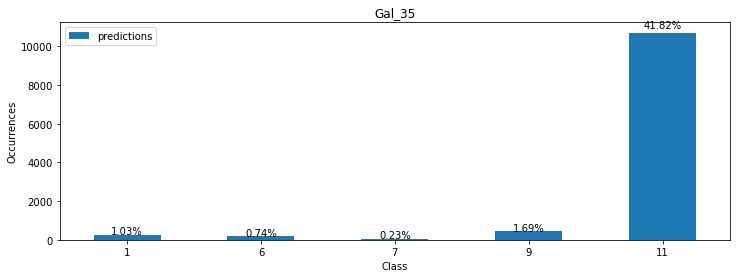

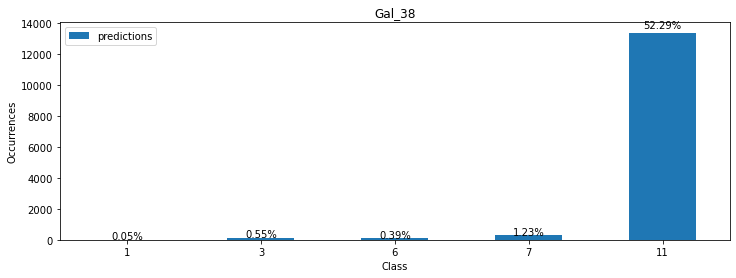

In [28]:
%%time

# For each sample id in the dataset, make a boxplot showing the percentage of each prediction cluster
# made by the model

for s in predicts_all['sample_id'].unique():
    print(s)
    pred = predicts_all[predicts_all['sample_id'] == s]
    p = pred['predictions'].value_counts().sort_index()
    p = pd.DataFrame(p)
    ax = p.plot.bar(rot=0, figsize=(12,4))
    ax.set_ylabel('Occurrences')
    ax.set_xlabel('Class')
    ax.set_title(s)
    
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{height / len(predicts_all) * 100 :.2f}%', (x + width/2, y + height*1.02), ha='center')

Wall time: 1.01 s


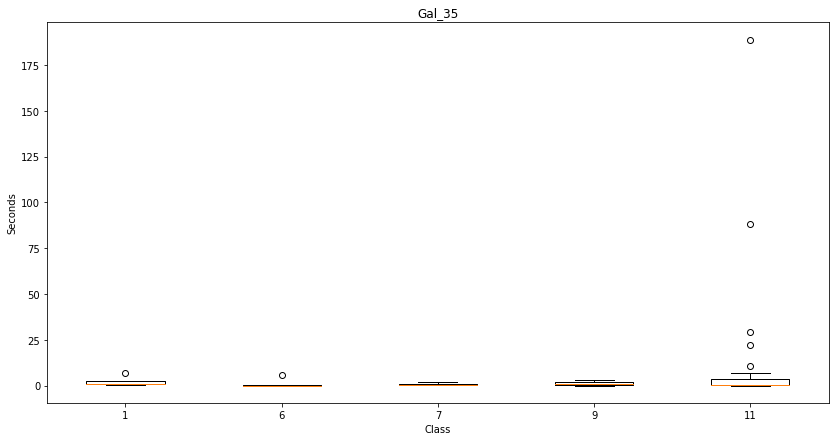

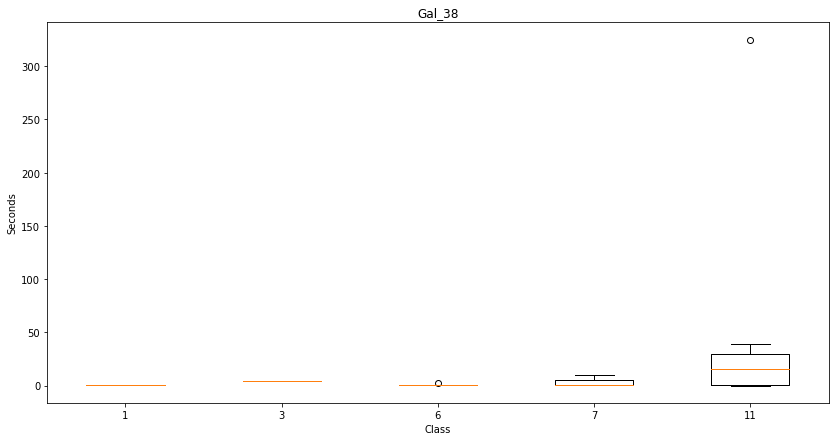

In [29]:
%%time
# For each sample id in the dataset, make a series of box and whisker plots showing the spread of bout length
# for each predicted cluster
columns_list = {}
frames_start_list = {}
frames_end_list = {}
for s in predicts_all['sample_id'].unique():
    pred = predicts_all[predicts_all['sample_id'] == s]
    pred.reset_index(inplace=True)
    columns = []
    frames_start = []
    frames_end = []
    count = 0
    for c in range(predictions.max() + 1):
        columns.append(str(c))
        frames_start.append(str(c))
        frames_end.append(str(c))
    columns = dict.fromkeys(columns)
    frames_start = dict.fromkeys(frames_start)
    frames_end = dict.fromkeys(frames_end)
    for c in columns:
        columns[str(c)] = []
        frames_start[str(c)] = []
        frames_end[str(c)] = []
    for i in range(len(pred)):
        if i == 0:
            count += 1
            frames_start[str(pred.at[i, 'predictions'])].append(i)
        elif i == len(pred) - 1:
            if pred.at[i, 'predictions'] == pred.at[(i - 1), 'predictions']:
                count += 1
                columns[str(pred.at[i, 'predictions'])].append(count)
                frames_end[str(pred.at[i, 'predictions'])].append(i)
                count = 0
            else:
                columns[str(pred.at[i - 1, 'predictions'])].append(count)
                frames_end[str(pred.at[i - 1, 'predictions'])].append(i - 1)
                frames_start[str(pred.at[i, 'predictions'])].append(i)
                columns[str(pred.at[i, 'predictions'])].append(1)
                frames_end[str(pred.at[i, 'predictions'])].append(i)
        else:
            if pred.at[i, 'predictions'] == pred.at[(i - 1), 'predictions']:
                count += 1
            else:
                columns[str(pred.at[i - 1, 'predictions'])].append(count)
                count = 1
                frames_end[str(pred.at[i - 1, 'predictions'])].append(i - 1)
                frames_start[str(pred.at[i, 'predictions'])].append(i)
    for i in columns:
        columns[i] = [element * 1 / 30 for element in columns[i]]
    
    columns_full = {k: v for k, v in columns.items() if not v == []}
    frames_start_full = {k: v for k, v in frames_start.items() if not v == []}
    frames_end_full = {k: v for k, v in frames_end.items() if not v == []}
    columns_list[s] = columns_full
    frames_start_list[s] = frames_start_full
    frames_end_list[s] = frames_end_full
    fig, ax = plt.subplots(figsize=(14,7))
    ax.boxplot(columns_full.values())
    ax.set_xticklabels(columns_full.keys())
    ax.set_ylabel('Seconds')
    ax.set_xlabel('Class')
    ax.set_title(s)

# Make gifs

In [30]:
%%time
# For each predicted cluster in a sample id's dataset, find the five longest bouts of each cluster and record the
# start and end frames in a video of each of those five bouts for each predicted cluster
gif_start_frames = {}
gif_end_frames = {}

for s in columns_list:
    start_frames = {}
    end_frames = {}
    for key in columns_list[s]:
        avg = sum(columns_list[s][key]) / len(columns_list[s][key])
        
        closest_test = columns_list[s][key][:]
        start_frame_list = []
        end_frame_list = []
        for i in range(5):
            closest_to_avg = min(closest_test, key=lambda x:abs(x-avg))
            index = columns_list[s][key].index(closest_to_avg)
            
            start_frame = frames_start_list[s][key][index]
            start_frame_list.append(start_frame)
            end_frame = frames_end_list[s][key][index]
            end_frame_list.append(end_frame)
            
            closest_test.remove(closest_to_avg)
            if closest_test == []:
                break
            
        start_frames[key] = start_frame_list
        end_frames[key] = end_frame_list
    
    gif_start_frames[s] = start_frames
    gif_end_frames[s] = end_frames
gif_end_frames

Wall time: 0 ns


{'Gal_35': {'1': [50, 109, 14, 320],
  '6': [1906, 1537, 1559, 1544, 1544],
  '7': [8945, 1, 9004],
  '9': [3020, 2602, 3059, 3275, 3072],
  '11': [1900, 2899, 488, 2565, 89]},
 'Gal_38': {'1': [14],
  '3': [547],
  '6': [2716, 3420, 2722, 1728, 1795],
  '7': [4206, 1, 4183],
  '11': [1725, 2695, 3411, 3890, 406]}}

In [115]:
%%time
# Extract the frames out of each video in the dataset
for s in predicts_all['sample_id'].unique():
    for video in videoname:
        if s in video:
            vidname = video
    vidcap = cv2.VideoCapture('videos\\' + vidname + '.mp4')
    success,image = vidcap.read()
    count = 0
    video_length = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    while success:
          cv2.imwrite("frames\\" + s + "\\frame%d.jpg" % count, image)     # save frame as JPEG file      
          success,image = vidcap.read()
          print('Read a new frame: ', success)
          count += 1

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

In [31]:
%%time
# Create frame arrays of each of the bout windows of frames determined above with the frames extracted previously
from os.path import isfile, join
for s in gif_start_frames:
    pathIn= 'frames//' + s
    fps = 30
    files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]

    #for sorting the file names properly
    files.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
    for key in gif_start_frames[s]:
        for i in range(len(gif_start_frames[s][key])):
            frame_array = []
            files_indexed = files[(gif_start_frames[s][key][i]):(gif_end_frames[s][key][i] + 1)]
            for j in range(len(files_indexed)):

                filename = pathIn + '\\' + files_indexed[j]
                #reading each files
                img = cv2.imread(filename)
                height, width, layers = img.shape            
                size = (width,height)

                    #inserting the frames into an image array
                frame_array.append(img)
            pathOut = 'gifs\\' + s + '_vids\\' + s + '_' + key + '_' + str(i) + '_example' + '.avi'
            out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
            for i in range(len(frame_array)):
                    # writing to a image array
                out.write(frame_array[i])
            out.release()

Wall time: 4min 22s


In [32]:
%%time
# Make gifs and avi files using imageio from each of the frame arrays made above and save them to the gifs folder
class TargetFormat(object):
    GIF = ".gif"
    MP4 = ".mp4"
    AVI = ".avi"

def convertFile(inputpath, outputpath):
    """Reference: http://imageio.readthedocs.io/en/latest/examples.html#convert-a-movie"""
    print("converting\r\n\t{0}\r\nto\r\n\t{1}".format(inputpath, outputpath))

    reader = imageio.get_reader(inputpath)
    fps = reader.get_meta_data()['fps']

    writer = imageio.get_writer(outputpath, fps=fps)
    for i,im in enumerate(reader):
        sys.stdout.write("\rframe {0}".format(i))
        sys.stdout.flush()
        writer.append_data(im)
    print("\r\nFinalizing...")
    writer.close()
    print("Done.")
for s in gif_start_frames:
    for key in gif_start_frames[s]:
        for i in range(len(gif_start_frames[s][key])):
            convertFile('gifs\\' + s + '_vids\\' + s + '_' + key + '_' + str(i) + '_example' + '.avi', 
                        'gifs\\' + s + '_gifs\\' + s + '_' + key + '_' + str(i) + '_example' + '.gif')

converting
	gifs\Gal_35_vids\Gal_35_1_0_example.avi
to
	gifs\Gal_35_gifs\Gal_35_1_0_example.gif
frame 20
Finalizing...
Done.
converting
	gifs\Gal_35_vids\Gal_35_1_1_example.avi
to
	gifs\Gal_35_gifs\Gal_35_1_1_example.gif
frame 19
Finalizing...
Done.
converting
	gifs\Gal_35_vids\Gal_35_1_2_example.avi
to
	gifs\Gal_35_gifs\Gal_35_1_2_example.gif
frame 12
Finalizing...
Done.
converting
	gifs\Gal_35_vids\Gal_35_1_3_example.avi
to
	gifs\Gal_35_gifs\Gal_35_1_3_example.gif
frame 209
Finalizing...
Done.
converting
	gifs\Gal_35_vids\Gal_35_6_0_example.avi
to
	gifs\Gal_35_gifs\Gal_35_6_0_example.gif
frame 5
Finalizing...
Done.
converting
	gifs\Gal_35_vids\Gal_35_6_1_example.avi
to
	gifs\Gal_35_gifs\Gal_35_6_1_example.gif
frame 4
Finalizing...
Done.
converting
	gifs\Gal_35_vids\Gal_35_6_2_example.avi
to
	gifs\Gal_35_gifs\Gal_35_6_2_example.gif
frame 1
Finalizing...
Done.
converting
	gifs\Gal_35_vids\Gal_35_6_3_example.avi
to
	gifs\Gal_35_gifs\Gal_35_6_3_example.gif
frame 0
Finalizing...
Done.
con

# Model performance

In [50]:
# Separate the feature dataset and labels into train and test sets using train test split
feats = f_10fps
labels = soft_assignments
feats_filt = feats[:, labels >= 0]
labels_filt = labels[labels >= 0]
feats_train, feats_test, labels_train, labels_test = train_test_split(feats_filt.T, labels_filt.T,
                                                                          test_size=0.2, random_state=42)



# Create a random forest classifier and fit it to the training data
classifier = RandomForestClassifier(random_state=42)
classifier.fit(feats_train, labels_train)

# Create a random forest classifier and fit it to the full dataset and make prediction on the same dataset
clf = RandomForestClassifier(random_state=42)
clf.fit(feats_filt.T, labels_filt.T)
predictions = clf.predict(feats.T)
   
# Run a cross validation on the test set using the first model above
scores = cross_val_score(classifier, feats_test, labels_test, cv=CV_IT, n_jobs=-1)

C:\Users\wrigh\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


In [51]:
# Calculate the mean and standard deviation of the cross validation scores
print("mean: ", round(scores.mean(), 2), "\nstd: ", round(scores.std(),2))

mean:  0.77 
std:  0.09


Non-normalized confusion matrix
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ... 619   0   0]
 [  0   0   0 ...   3  37   0]
 [  0   0   0 ...   0   0   0]]
Normalized confusion matrix
[[0.           0.           0.           ... 0.           0.
  0.          ]
 [0.           0.           0.           ... 0.           0.
  0.          ]
 [0.           0.           0.           ... 0.           0.
  0.          ]
 ...
 [0.           0.           0.           ... 0.9732704403 0.
  0.          ]
 [0.           0.           0.           ... 0.075        0.925
  0.          ]
 [0.           0.           0.           ... 0.           0.
  0.          ]]


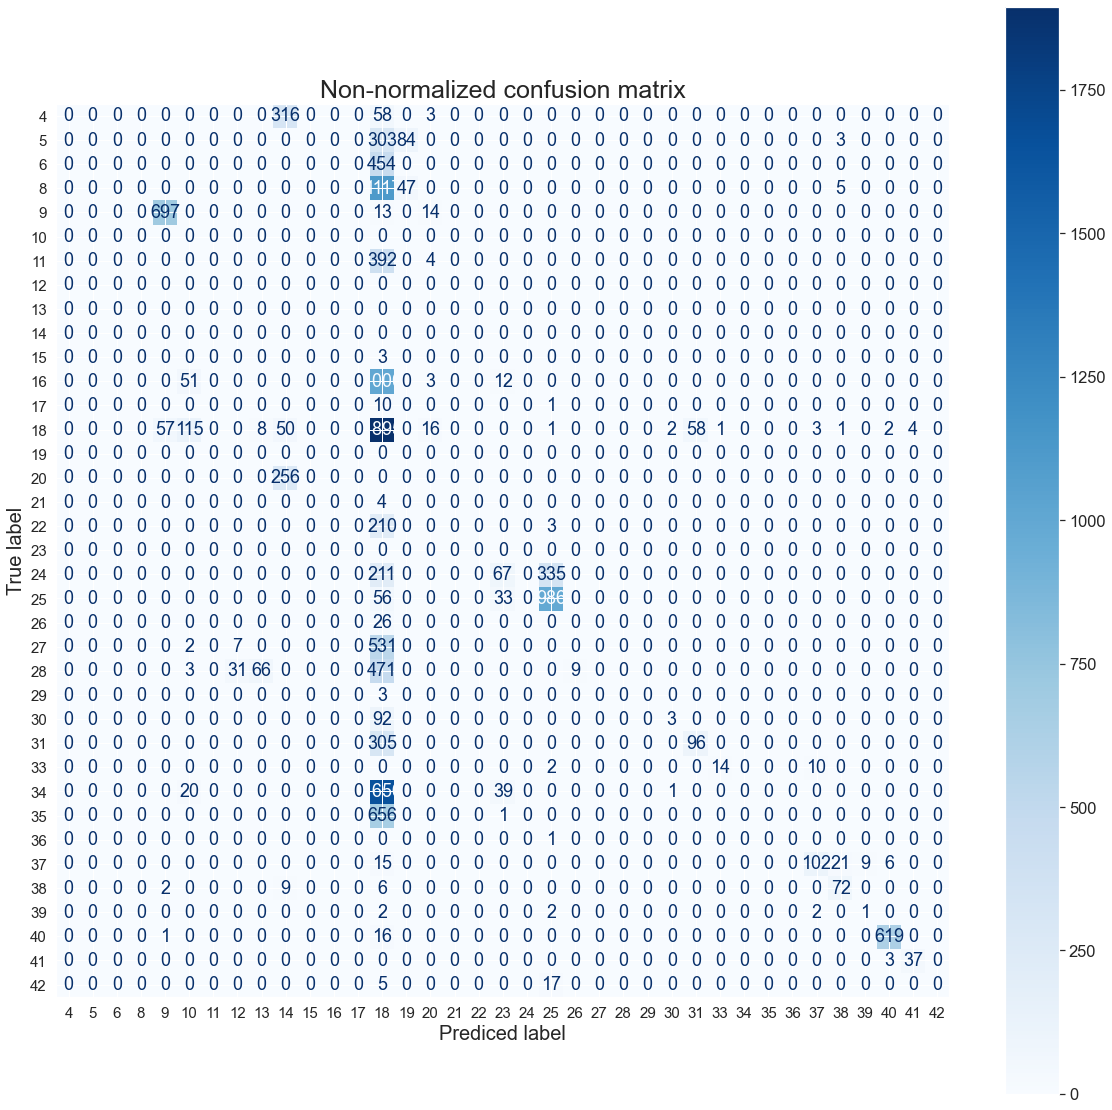

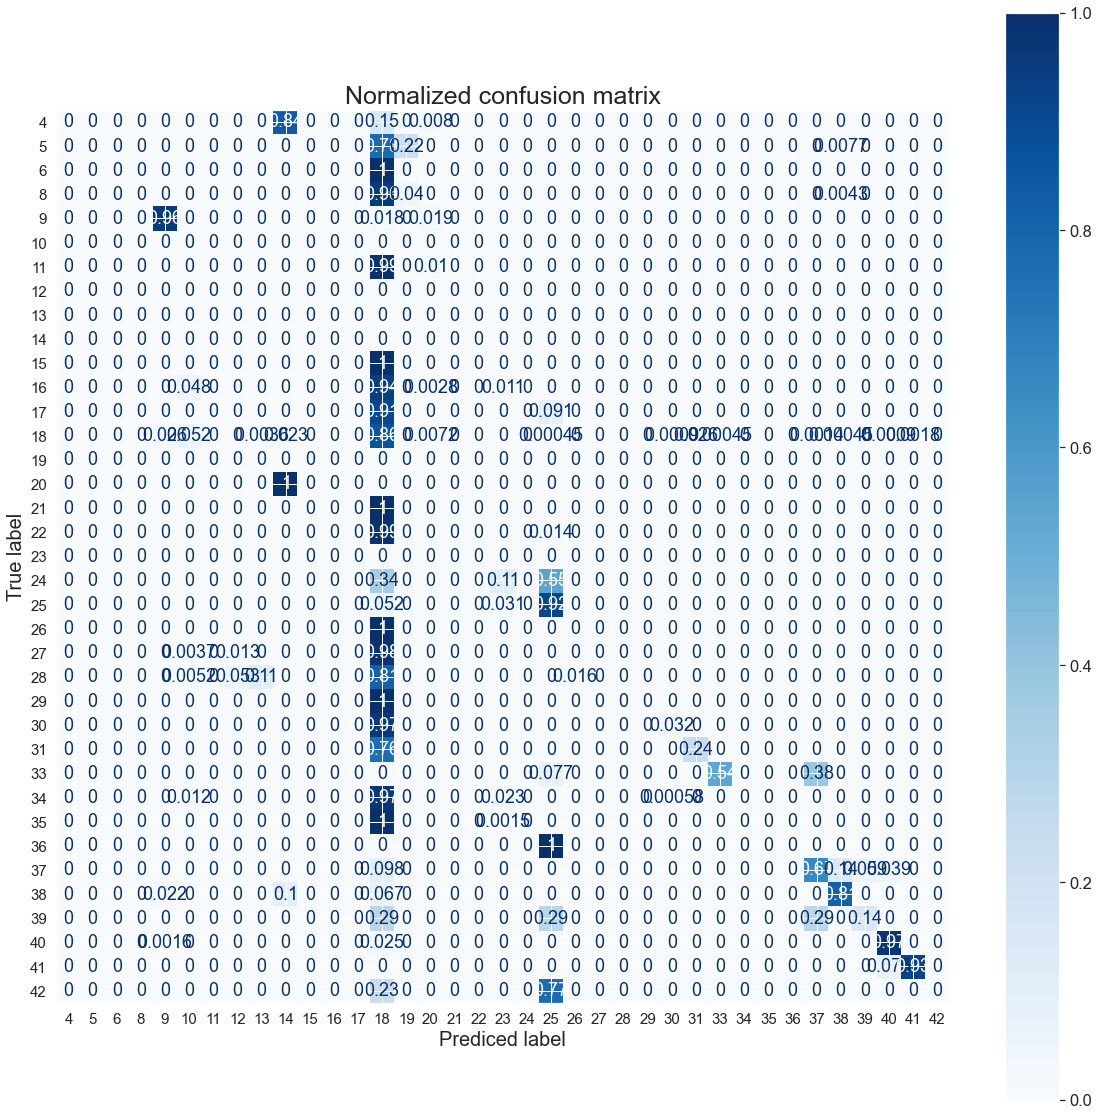

In [52]:
# Plot a normalized and non-normalized confusion matrix for the model and the test set
np.set_printoptions(precision=10)
sns.set(font_scale=1.5)

titles_options = [("Non-normalized confusion matrix", None),
                          ("Normalized confusion matrix", 'true')]
titlenames = [("counts"), ("norm")]
j = 0
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(20, 20))
    disp = plot_confusion_matrix(classifier, feats_test, labels_test,
                                         cmap=plt.cm.Blues,
                                         normalize=normalize, ax=ax)
    disp.ax_.set_title(title, fontsize=25)
    disp.ax_.set_xlabel("Prediced label", fontsize=20)
    disp.ax_.set_ylabel("True label", fontsize=20)
    disp.ax_.set_xticklabels(disp.display_labels, fontsize=15)
    disp.ax_.set_yticklabels(disp.display_labels, fontsize=15)
    print(title)
    print(disp.confusion_matrix)
    my_file = 'confusion_matrix_{}'.format(titlenames[j])
    j += 1

plt.show()